In [1]:
import pycaret
import pandas as pd

In [2]:
# อ่านไฟล์ CSV
data = pd.read_csv('../../export_data_jsp01/clean_data_jsps001_1d.csv')

In [3]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data[data.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data[data.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


# row = data.loc["2023-09-30 07:00:00"]
# row

แถวที่มีค่าหายไปก่อนเติม:
Empty DataFrame
Columns: [humidity, pm_2_5, temperature]
Index: []
ไม่มีค่าหายไปแล้ว


In [4]:
data = data[['temperature']]

In [5]:
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week  # ค่าจะเป็น int64

# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

import pandas as pd
import numpy as np

# สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว
# เพิ่มฟีเจอร์ day_of_year
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_year'] = data['date'].dt.dayofyear

# เพิ่มฟีเจอร์ month_sin และ month_cos
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

lag_size = 7
for i in range(1,lag_size+1):
    data[f'temperature_lag_{i}'] = data['temperature'].shift(i)


In [6]:
data_filtered = data.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

In [7]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 30

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)



In [8]:
from pycaret.regression import load_model, predict_model

model_temp = load_model("ada_and_dt_jsps01_temp_model")

Transformation Pipeline and Model Successfully Loaded


In [9]:
data_compare = data_filtered.loc[:'2025-01-12']
result = pd.DataFrame()

start_date = "2025-01-13"
end_date = "2025-02-11"

model = model_temp

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    for i in range(1,lag_size+1):
        data_compare[f'temperature_lag_{i}'] = data_compare['temperature'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['temperature'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'temperature'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result
    result = pd.concat([result, predict_test_1], axis=0)

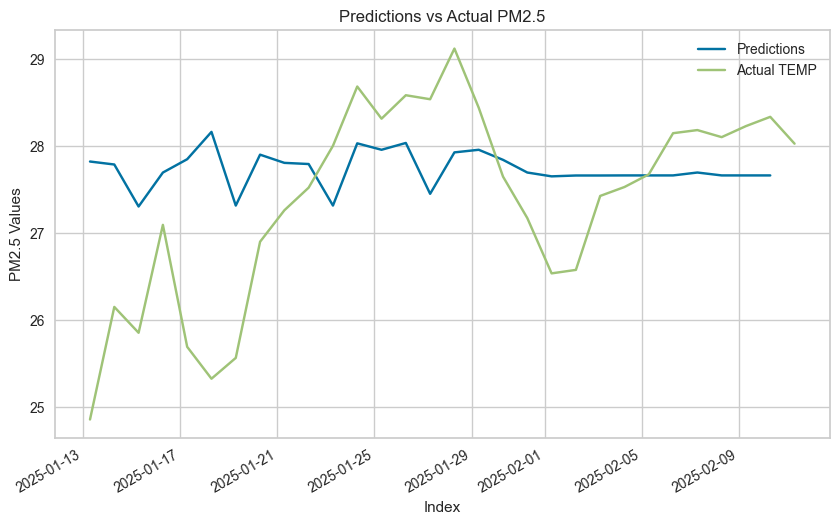

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['temperature']], axis=1)
result_plot.columns = ['Predictions', 'Actual TEMP']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual PM2.5')
plt.xlabel('Index')
plt.ylabel('PM2.5 Values')

# แสดงกราฟ
plt.show()

In [11]:
y_true = test_data["temperature"][:"2025-2-10"]
y_pred = result["prediction_label"].shift(-1).dropna(axis=0)

In [12]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: -0.1035
Mean Absolute Error (MAE): 0.9031
Root Mean Squared Error (RMSE): 1.1676
Mean Absolute Percentage Error (MAPE): 3.39%
Accuracy: 96.61%


In [13]:
result.tail()

,year,month,day,day_of_week,week_of_year,season,is_weekend,date,day_of_year,month_sin,...,day_of_week_sin,day_of_week_cos,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_4,temperature_lag_5,temperature_lag_6,temperature_lag_7,prediction_label
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-07 07:00:00,2025,2,7,4,6,0,0,2025-02-07,38,0.866025,...,-0.433884,-0.900969,27.664705,27.664705,27.663752,27.663752,27.653965,27.697985,27.843803,27.664705
2025-02-08 07:00:00,2025,2,8,5,6,0,1,2025-02-08,39,0.866025,...,-0.974928,-0.222521,27.664705,27.664705,27.664705,27.663752,27.663752,27.653965,27.697985,27.697985
2025-02-09 07:00:00,2025,2,9,6,6,0,1,2025-02-09,40,0.866025,...,-0.781832,0.623490,27.697985,27.664705,27.664705,27.664705,27.663752,27.663752,27.653965,27.664705
2025-02-10 07:00:00,2025,2,10,0,7,0,0,2025-02-10,41,0.866025,...,0.000000,1.000000,27.664705,27.697985,27.664705,27.664705,27.664705,27.663752,27.663752,27.664705
2025-02-11 07:00:00,2025,2,11,1,7,0,0,2025-02-11,42,0.866025,...,0.781832,0.623490,27.664705,27.664705,27.697985,27.664705,27.664705,27.664705,27.663752,27.664705


------------------

In [14]:
# อ่านไฟล์ CSV
data = pd.read_csv('../../export_data_jsp01/clean_data_jsps001_1d.csv')

In [15]:
# ตั้ง 'timestamp' เป็น index หากยังไม่ได้ทำ
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# ตั้งค่า freq ให้กับ index
data = data.asfreq('D')  # 'D' สำหรับรายวัน

In [16]:
data.tail()

,humidity,pm_2_5,temperature
timestamp,,,
2025-02-07 07:00:00,72.053758,27.864365,28.186164
2025-02-08 07:00:00,72.759274,33.923883,28.104894
2025-02-09 07:00:00,69.850659,32.647832,28.231867
2025-02-10 07:00:00,69.598712,32.856690,28.338313
2025-02-11 07:00:00,71.713989,34.038326,28.029813


In [17]:
# แสดงแถวที่มีค่าหายไปก่อนเติม
print("แถวที่มีค่าหายไปก่อนเติม:")
print(data[data.isnull().any(axis=1)])

# เติมค่าที่หายไปด้วยการ interpolate แบบเส้นตรง
data.interpolate(method='linear', inplace=True)

# แสดงแถวที่ยังมีค่า NaN หลังจากเติม (ถ้ามี)
missing_rows_after = data[data.isnull().any(axis=1)]
if not missing_rows_after.empty:
    print("แถวที่ยังมีค่าหายไปหลังเติม:")
    print(missing_rows_after)
else:
    print("ไม่มีค่าหายไปแล้ว")


row = data.loc["2023-09-30 07:00:00"]
row

แถวที่มีค่าหายไปก่อนเติม:
Empty DataFrame
Columns: [humidity, pm_2_5, temperature]
Index: []
ไม่มีค่าหายไปแล้ว


humidity       75.436933
pm_2_5         41.697658
temperature    30.098761
Name: 2023-09-30 07:00:00, dtype: float64

In [18]:
# add temp predict column
shifted_predictions_temp = result['prediction_label'].shift(-1).iloc[:-1]

data.loc[shifted_predictions_temp.index, 'temperature'] = shifted_predictions_temp
data.tail(30)

,humidity,pm_2_5,temperature
timestamp,,,
2025-01-13 07:00:00,75.720718,30.592321,27.824428
2025-01-14 07:00:00,69.815912,33.313586,27.790195
2025-01-15 07:00:00,75.254666,50.672600,27.307275
2025-01-16 07:00:00,75.413310,49.521314,27.697801
2025-01-17 07:00:00,87.503481,22.819705,27.851053
2025-01-18 07:00:00,85.722029,33.084067,28.165335
2025-01-19 07:00:00,78.304175,40.635307,27.317966
2025-01-20 07:00:00,76.309167,49.684027,27.903474
2025-01-21 07:00:00,77.957346,46.786058,27.809075


In [19]:
data = data[['humidity', 'temperature']]

In [20]:
data["year"] = data.index.year
data["month"] = data.index.month
data["day"] = data.index.day
data["day_of_week"] = data.index.dayofweek  # 0 = Monday, 6 = Sunday
data["week_of_year"] = data.index.isocalendar().week  # ค่าจะเป็น int64

In [21]:
# สมมติว่า data มี index เป็น datetime อยู่แล้ว
def assign_season(month):
    if month in [2, 3, 4]:  # ก.พ. - เม.ย.
        return "summer"        # ฤดูร้อน
    elif month in [5, 6, 7]:  # พ.ค. - ก.ค.
        return "early_rainy"   # ต้นฤดูฝน
    else:  # ส.ค. - ม.ค.
        return "late_rainy"    # ปลายฤดูฝน

season_mapping = {'summer': 0, 'early_rainy': 1, 'late_rainy': 2}
data["season"] = data.index.month.map(assign_season)
data['season'] = data['season'].map(season_mapping)

In [22]:
data["is_weekend"] = data.index.dayofweek.isin([5, 6]).astype(int)

In [23]:
import pandas as pd
import numpy as np

# สมมุติว่ามี DataFrame data ที่มีข้อมูลอยู่แล้ว
# เพิ่มฟีเจอร์ day_of_year
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
data['day_of_year'] = data['date'].dt.dayofyear

# # เพิ่มฟีเจอร์ month_sin และ month_cos
# data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
# data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# # เพิ่มฟีเจอร์ day_of_week_sin และ day_of_week_cos
# data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
# data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

lag_size = 7
for i in range(1,lag_size+1):
    data[f'humidity_lag_{i}'] = data['humidity'].shift(i)

for i in range(1,lag_size+1):
    data[f'temperature_lag_{i}'] = data['temperature'].shift(i)

In [24]:
# data["temp_diff"] = data["temperature"].diff()

In [25]:
data.columns

Index(['humidity', 'temperature', 'year', 'month', 'day', 'day_of_week',
       'week_of_year', 'season', 'is_weekend', 'date', 'day_of_year',
       'humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_4',
       'humidity_lag_5', 'humidity_lag_6', 'humidity_lag_7',
       'temperature_lag_1', 'temperature_lag_2', 'temperature_lag_3',
       'temperature_lag_4', 'temperature_lag_5', 'temperature_lag_6',
       'temperature_lag_7'],
      dtype='object')

In [26]:
data_filtered = data.loc['2023-09':]  # ดึงข้อมูลตั้งแต่กันยายน 2023 เป็นต้นไป

<Axes: xlabel='timestamp'>

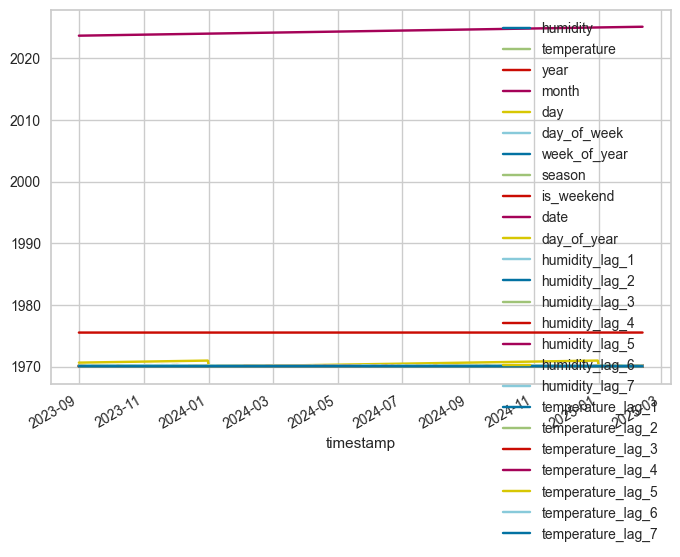

In [27]:
data_filtered.plot()

In [28]:
# สมมติว่า data มีจำนวนวันทั้งหมด
total_data = len(data_filtered)

# จำนวนวันที่ต้องการเป็น test data
test_days = 30

# คำนวณสัดส่วนของ 30 วันในข้อมูลทั้งหมด
test_size = test_days / total_data
test_size

0.05660377358490566

In [29]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data_filtered, test_size=test_size, shuffle=False)

In [30]:
train_data.shape

(500, 25)

In [31]:
test_data.shape

(30, 25)

In [32]:
test_data.head(1)

,humidity,temperature,year,month,day,day_of_week,week_of_year,season,is_weekend,date,...,humidity_lag_5,humidity_lag_6,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_4,temperature_lag_5,temperature_lag_6,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-01-13 07:00:00,75.720718,27.824428,2025,1,13,0,3,2,0,2025-01-13,...,73.449632,73.350454,85.925103,26.640566,28.05223,28.380074,28.482274,28.022162,27.094928,25.455684


In [33]:
test_data.tail(1)

,humidity,temperature,year,month,day,day_of_week,week_of_year,season,is_weekend,date,...,humidity_lag_5,humidity_lag_6,humidity_lag_7,temperature_lag_1,temperature_lag_2,temperature_lag_3,temperature_lag_4,temperature_lag_5,temperature_lag_6,temperature_lag_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-02-11 07:00:00,71.713989,28.029813,2025,2,11,1,7,0,0,2025-02-11,...,70.853854,70.575618,71.844422,27.664705,27.664705,27.664705,27.697985,27.664705,27.664705,27.664705


In [34]:
test_data.columns

Index(['humidity', 'temperature', 'year', 'month', 'day', 'day_of_week',
       'week_of_year', 'season', 'is_weekend', 'date', 'day_of_year',
       'humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3', 'humidity_lag_4',
       'humidity_lag_5', 'humidity_lag_6', 'humidity_lag_7',
       'temperature_lag_1', 'temperature_lag_2', 'temperature_lag_3',
       'temperature_lag_4', 'temperature_lag_5', 'temperature_lag_6',
       'temperature_lag_7'],
      dtype='object')

In [35]:
# from pycaret.time_series import *
from pycaret.regression import RegressionExperiment
exp1 = RegressionExperiment()
exp1.setup(data=train_data, target='humidity', session_id=123, fold=12, iterative_imputation_iters=100, remove_outliers = True)
# iterative_imputation_iters=100, remove_outliers = True

,Description,Value
0,Session id,123
1,Target,humidity
2,Target type,Regression
3,Original data shape,"(500, 25)"
4,Transformed data shape,"(482, 27)"
5,Transformed train set shape,"(332, 27)"
6,Transformed test set shape,"(150, 27)"
7,Numeric features,23
8,Date features,1
9,Preprocess,True


In [36]:
# compare baseline models
best = exp1.compare_models(n_select=15)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,1.7562,5.4522,2.2939,0.8954,0.0300,0.0232,0.0183
ridge,Ridge Regression,1.7613,5.4670,2.2995,0.8950,0.0301,0.0232,0.0183
lr,Linear Regression,1.7716,5.5280,2.3115,0.8940,0.0303,0.0234,0.2658
et,Extra Trees Regressor,1.9843,7.0556,2.5876,0.8642,0.0334,0.0260,0.0442
lightgbm,Light Gradient Boosting Machine,2.0259,7.2825,2.6473,0.8603,0.0343,0.0266,0.0475
gbr,Gradient Boosting Regressor,2.0438,7.6474,2.7137,0.8525,0.0353,0.0269,0.0392
rf,Random Forest Regressor,2.2126,8.7819,2.9012,0.8292,0.0375,0.0290,0.0625
ada,AdaBoost Regressor,2.3523,9.5132,3.0278,0.8153,0.0391,0.0308,0.0283
lasso,Lasso Regression,2.3957,9.8793,3.0532,0.8119,0.0393,0.0313,0.0200
llar,Lasso Least Angle Regression,2.4024,9.9319,3.0600,0.8107,0.0394,0.0313,0.0217


In [37]:
# model_1 = exp1.create_model('rf')
model_1 = exp1.create_model('rf')
model_2 = exp1.create_model('ridge')
model_3 = exp1.create_model('br')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.6678,14.7489,3.8404,0.6955,0.0498,0.0364
1,2.5452,10.8875,3.2996,0.8034,0.0434,0.0341
2,2.4591,9.8572,3.1396,0.8493,0.0408,0.0317
3,2.1847,8.7465,2.9575,0.8649,0.0371,0.0284
4,1.9022,6.5687,2.5630,0.8502,0.0351,0.0262
5,1.8291,5.0373,2.2444,0.9138,0.0287,0.0239
6,1.2914,2.9862,1.7281,0.9533,0.0206,0.0160
7,2.7377,14.1897,3.7669,0.6415,0.0500,0.0357
8,2.5386,10.4964,3.2398,0.8371,0.0404,0.0318


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.4516,5.0015,2.2364,0.8967,0.0299,0.0201
1,1.9881,6.5555,2.5604,0.8817,0.0341,0.0269
2,1.7799,4.9548,2.2259,0.9242,0.0293,0.0233
3,2.1240,7.0737,2.6597,0.8908,0.0339,0.0277
4,1.5116,4.3549,2.0868,0.9007,0.0291,0.0209
5,1.4511,3.1305,1.7693,0.9464,0.0236,0.0193
6,1.2994,2.6118,1.6161,0.9592,0.0207,0.0166
7,2.2102,8.3773,2.8943,0.7884,0.0377,0.0291
8,2.1121,7.7474,2.7834,0.8798,0.0349,0.0267


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.4493,4.9972,2.2354,0.8968,0.0299,0.0201
1,2.0169,6.6818,2.5849,0.8794,0.0344,0.0272
2,1.7565,4.9309,2.2206,0.9246,0.0292,0.0230
3,2.1203,7.1522,2.6744,0.8896,0.0341,0.0276
4,1.5033,4.3381,2.0828,0.9011,0.0290,0.0208
5,1.4332,3.0416,1.7440,0.9480,0.0233,0.0190
6,1.3089,2.5257,1.5892,0.9605,0.0202,0.0167
7,2.2066,8.5222,2.9193,0.7847,0.0380,0.0290
8,2.1111,7.7879,2.7907,0.8791,0.0349,0.0267


In [38]:
# exp1.evaluate_model(model_1)

In [39]:
predictions = exp1.predict_model(model_2, data=test_data)
predict_v = predictions['prediction_label']
real = test_data['humidity']

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.9298,15.7690,3.9710,0.2418,0.0512,0.0390


In [40]:
# exp1.plot_model(model_2, 'learning')

# ทำนาย 1 วันข้างหน้า ต้องทำนายเผื่อ 2 วัน

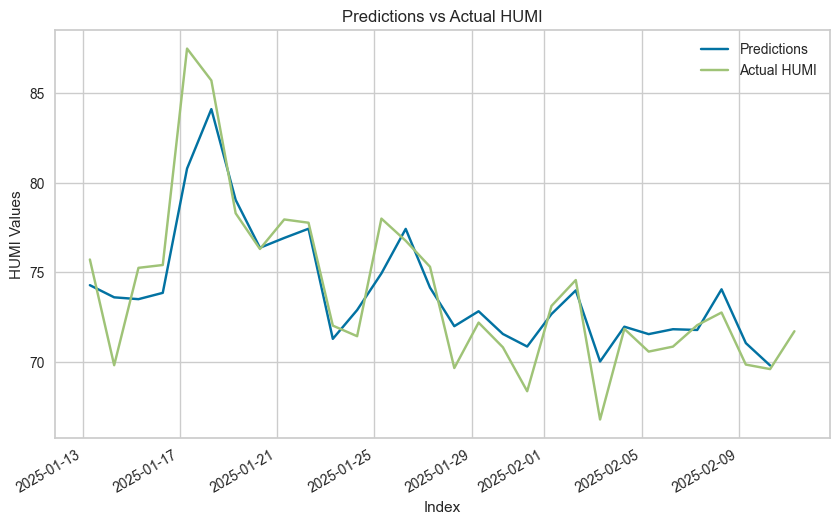

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result = pd.concat([predict_v.shift(-1), test_data['humidity']], axis=1)
result.columns = ['Predictions', 'Actual HUMI']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual HUMI')
plt.xlabel('Index')
plt.ylabel('HUMI Values')

# แสดงกราฟ
plt.show()

In [42]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

y_true = test_data["humidity"][:"2025-2-10"]
y_pred = predict_v.shift(-1).dropna(axis=0)

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate Accuracy as (1 - (MAE / mean_actual)) * 100
mean_actual = np.mean(y_true)  # Mean of actual values
accuracy = (1 - (mae / mean_actual)) * 100  # Accuracy in percentage

# Print Results
print(f"R² Score: {r2:.4f}")  # Closer to 1 is better
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Lower is better
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Lower is better
print(f"Accuracy: {accuracy:.2f}%")  # Accuracy percentage

R² Score: 0.8161
Mean Absolute Error (MAE): 1.4353
Root Mean Squared Error (RMSE): 1.9812
Accuracy: 98.06%


In [43]:
from pycaret.regression import *
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Extract actual values and predicted values
y_true = test_data["humidity"][:"2025-2-10"]
y_pred = predict_v.shift(-1).dropna(axis=0)

# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: 0.8161
Mean Absolute Error (MAE): 1.4353
Root Mean Squared Error (RMSE): 1.9812
Mean Absolute Percentage Error (MAPE): 1.92%
Accuracy: 98.08%


# Predict 1 by 1

30 วัน  
2025-01-13 07:00:00  
2025-02-11 07:00:00  
7 วัน  
2025-02-05  
2025-02-11  
24 วัน  
2025-01-19 07:00:00  
31 วัน
2025-01-12 07:00:00

In [44]:
data_compare = data_filtered.loc[:'2025-01-12']
result = pd.DataFrame()

start_date = "2025-01-13"
end_date = "2025-02-11"

model = model_3

for date in pd.date_range(start=start_date, end=end_date, freq="D"):
    # Drop columns
    test_1 = data_filtered
    # ดึงวันนี้มา
    test_1 = test_1.loc[str(date.date())]

    # ใส่เข้าไป
    data_compare = pd.concat([data_compare, test_1], axis=0)

    # เพิ่มฟีเจอร์ rolling average (ค่าเฉลี่ยเคลื่อนที่)

    # data_compare['pm_2_5_rolling_7'] = data_compare['pm_2_5'].rolling(window=7).mean().shift(1)  # ค่าเฉลี่ย 5 วันของ PM 10

    for i in range(1,lag_size+1):
        data_compare[f'humidity_lag_{i}'] = data_compare['humidity'].shift(i)

    # ดึง
    test_1 = (data_compare.loc[str(date.date())]).drop(columns=['humidity'])
    
    # Drop ทิ้งล่าสุดใน data_compare
    data_compare = data_compare.drop(data_compare.last_valid_index())
    test_1 = test_1[~test_1.index.duplicated(keep='last')]

    # Predict
    predict_test_1 = exp1.predict_model(model, data=test_1)

    # เพิ่มผลทำนายเข้าไปใน data_compare
    data_compare = pd.concat([data_compare, predict_test_1], axis=0)

    # แทนที่ค่าในคอลัมน์ 'pm_2_5' ในวันที่ '2025-01-13' ด้วยค่าในคอลัมน์ 'prediction_label'
    data_compare.loc[str(date.date()), 'humidity'] = data_compare.loc[str(date.date()), 'prediction_label']

    # ลบคอลัมน์ 'prediction_label' (หากต้องการแค่ผลทำนาย)
    data_compare = data_compare.drop(columns=['prediction_label'])

    # กรองเอาวันที่ซ้ำกัน (index ซ้ำ) ออกให้เหลือแค่ตัวเดียว
    data_compare = data_compare[~data_compare.index.duplicated(keep='last')]

    # บันทึกลง result
    result = pd.concat([result, predict_test_1], axis=0)

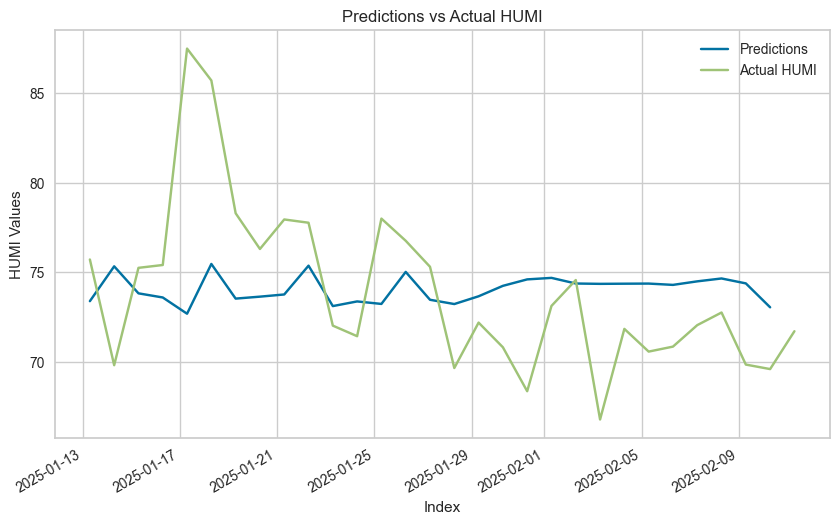

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

real_data = data_filtered.loc[start_date:end_date]
# สมมุติว่า result คือ DataFrame ที่รวม predictions กับ pm_10
result_plot = pd.concat([result['prediction_label'].shift(-1), real_data['humidity']], axis=1)
result_plot.columns = ['Predictions', 'Actual HUMI']  # ตั้งชื่อคอลัมน์

# พล็อตข้อมูล
result_plot.plot(figsize=(10, 6))

# ตั้งชื่อกราฟ
plt.title('Predictions vs Actual HUMI')
plt.xlabel('Index')
plt.ylabel('HUMI Values')

# แสดงกราฟ
plt.show()

In [46]:
y_true = test_data["humidity"][:"2025-2-10"]
y_pred = result['prediction_label'].shift(-1).dropna(axis=0)

In [47]:
# Calculate Regression Metrics
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Calculate MAPE and Accuracy
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
accuracy = 100 - mape  # Convert to Accuracy %

# Print Results
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

R² Score: -0.0558
Mean Absolute Error (MAE): 3.7147
Root Mean Squared Error (RMSE): 4.7467
Mean Absolute Percentage Error (MAPE): 4.94%
Accuracy: 95.06%


In [48]:
exp1.save_model(model_3, "br_humi_u_temp_model_jsps01")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['date'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['temperature', 'year', 'month',
                                              'day', 'day_of_week',
                                              'week_of_year', 'season',
                                              'is_weekend', 'day_of_year',
                                              'humidity_lag_1', 'humidity_lag_2',
                                              'humidity_lag_3', 'hu...
                                              'temperature_lag_3',
                                              'temperature_lag_4',
                                              'temperature_lag_5',
                                              'temperature_lag_6',
                              

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# แปลง index เป็น datetime และลบเวลาออก
x = data_filtered.copy()
x.index = pd.to_datetime(x.index).normalize()

# เก็บผลลัพธ์ของแต่ละโมเดล
result_dict = {}

# รายชื่อโมเดลทั้งหมดจาก best_list
model_names = {model.__class__.__name__: model for model in best}

start_date = "2025-01-13"
end_date = "2025-02-11"

# วนลูปผ่านทุกโมเดล
for model_name, model in model_names.items():
    print(f"Processing model: {model_name}")

    data_compare = x.loc[:'2025-01-12'].copy()  # ใช้ copy() ป้องกัน Warning
    result = pd.DataFrame()

    for date in pd.date_range(start=start_date, end=end_date, freq="D"):
        # ลบเวลาออกจากวันที่
        date = pd.to_datetime(date).normalize()  # ลบเวลาออกจากตัวแปร date

        # ตรวจสอบว่าใน x มีข้อมูลในวันที่นี้หรือไม่
        if date not in x.index:
            print(f"⚠️ Warning: Date {date} not found in x index.")
            continue

        # ดึงข้อมูลของวันที่ต้องการ
        test_1 = x.loc[[date]].copy()

        # ใส่เข้าไป
        data_compare = pd.concat([data_compare, test_1], axis=0)

        # เพิ่ม lag feature
        for i in range(1, lag_size + 1):
            test_1[f'humidity_lag_{i}'] = data_compare['humidity'].shift(i).iloc[-1]

        # ลบค่า NaN ที่เกิดจากการ shift
        test_1 = test_1.dropna()

        # ทำนายค่า
        predict_test_1 = exp1.predict_model(model, data=test_1)

        # อัปเดต data_compare
        predict_test_1.index = [date]  # กำหนด index เป็นวันที่พยากรณ์
        data_compare.loc[date, 'humidity'] = predict_test_1['prediction_label'].values[0]

        # บันทึกผลลัพธ์
        result = pd.concat([result, predict_test_1], axis=0)

    # บันทึกผลลัพธ์ของโมเดลนี้ลง dict
    result_dict[model_name] = result

# --------------------------------------------
# พล็อตกราฟเปรียบเทียบทุกโมเดล
# --------------------------------------------
real_data = x.loc[start_date:end_date]

# วนลูปพล็อตกราฟทีละโมเดล
for model_name, result in result_dict.items():
    plt.figure(figsize=(12, 6))
    
    result_plot = pd.concat([result['prediction_label'], real_data['humidity']], axis=1)
    result_plot.columns = ['Predictions', 'Actual TEMP']

    plt.plot(result_plot.index, result_plot['Predictions'], label=f"Predicted ({model_name})")
    plt.plot(real_data.index, real_data['humidity'], label="Actual TEMP", color="black", linewidth=2)
    
    # ตั้งค่ากราฟ
    plt.title(f'Predictions vs Actual TEMP for {model_name}')
    plt.xlabel('Date')
    plt.ylabel('TEMP Values')
    plt.legend()

    # แสดงกราฟ
    plt.show()

Processing model: BayesianRidge


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.6580,2.7491,1.6580,nan,0.0218,0.0219


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.5774,12.7975,3.5774,nan,0.0493,0.0512


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.0844,0.0071,0.0844,nan,0.0011,0.0011


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.5833,2.5070,1.5833,nan,0.0209,0.0210


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,13.9043,193.3304,13.9043,nan,0.1709,0.1589


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,13.0305,169.7945,13.0305,nan,0.1628,0.1520


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.8322,8.0214,2.8322,nan,0.0364,0.0362


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.7732,7.6907,2.7732,nan,0.0365,0.0363


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,4.3120,18.5938,4.3120,nan,0.0562,0.0553


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,4.0079,16.0630,4.0079,nan,0.0522,0.0515


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.3497,11.2203,3.3497,nan,0.0448,0.0465


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.6821,2.8294,1.6821,nan,0.0230,0.0235


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,4.6269,21.4082,4.6269,nan,0.0603,0.0593


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.5280,12.4465,3.5280,nan,0.0464,0.0460


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.2872,0.0825,0.2872,nan,0.0038,0.0038


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.8131,14.5397,3.8131,nan,0.0526,0.0547


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.0368,1.0750,1.0368,nan,0.0141,0.0144


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.8480,8.1110,2.8480,nan,0.0389,0.0402


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,5.8869,34.6558,5.8869,nan,0.0815,0.0861


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.4825,2.1978,1.4825,nan,0.0198,0.0203


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.1203,0.0145,0.1203,nan,0.0016,0.0016


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,7.5961,57.7011,7.5961,nan,0.1062,0.1137


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.5157,6.3289,2.5157,nan,0.0340,0.0350


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.7934,14.3901,3.7934,nan,0.0516,0.0537


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,3.5217,12.4021,3.5217,nan,0.0478,0.0497


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,2.2486,5.0563,2.2486,nan,0.0303,0.0312


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.7409,3.0306,1.7409,nan,0.0233,0.0239


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,4.8103,23.1393,4.8103,nan,0.0657,0.0689


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,4.7872,22.9172,4.7872,nan,0.0656,0.0688


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,1.3360,1.7848,1.3360,nan,0.0182,0.0186


Processing model: Ridge


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.7264,2.9803,1.7264,nan,0.0228,0.0228


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.5271,12.4402,3.5271,nan,0.0486,0.0505


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.0565,0.0032,0.0565,nan,0.0007,0.0008


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.6456,2.7078,1.6456,nan,0.0218,0.0218


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,13.9818,195.4903,13.9818,nan,0.1720,0.1598


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,13.0993,171.5906,13.0993,nan,0.1638,0.1528


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.8438,8.0874,2.8438,nan,0.0365,0.0363


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.8423,8.0789,2.8423,nan,0.0375,0.0372


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,4.3375,18.8141,4.3375,nan,0.0565,0.0556


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,4.0450,16.3621,4.0450,nan,0.0527,0.0520


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.3657,11.3277,3.3657,nan,0.0451,0.0467


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.6154,2.6095,1.6154,nan,0.0221,0.0226


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,4.6612,21.7266,4.6612,nan,0.0608,0.0598


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.5832,12.8393,3.5832,nan,0.0472,0.0467


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.2743,0.0752,0.2743,nan,0.0036,0.0036


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.7692,14.2065,3.7692,nan,0.0520,0.0541


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.0137,1.0277,1.0137,nan,0.0138,0.0140


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.8299,8.0083,2.8299,nan,0.0386,0.0400


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,5.8815,34.5915,5.8815,nan,0.0814,0.0860


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.4505,2.1038,1.4505,nan,0.0194,0.0198


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.0757,0.0057,0.0757,nan,0.0010,0.0010


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,7.5581,57.1255,7.5581,nan,0.1057,0.1132


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.4693,6.0973,2.4693,nan,0.0333,0.0344


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.7451,14.0259,3.7451,nan,0.0510,0.0531


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,3.4674,12.0227,3.4674,nan,0.0471,0.0489


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,2.1911,4.8010,2.1911,nan,0.0296,0.0304


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.6736,2.8008,1.6736,nan,0.0224,0.0230


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,4.7354,22.4244,4.7354,nan,0.0647,0.0678


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,4.7257,22.3319,4.7257,nan,0.0648,0.0679


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,1.2422,1.5431,1.2422,nan,0.0169,0.0173


Processing model: LinearRegression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.5166,2.3001,1.5166,nan,0.0200,0.0200


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.8669,14.9529,3.8669,nan,0.0532,0.0554


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.4827,0.2330,0.4827,nan,0.0063,0.0064


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.1274,1.2709,1.1274,nan,0.0149,0.0149


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,13.4060,179.7197,13.4060,nan,0.1643,0.1532


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,12.4420,154.8040,12.4420,nan,0.1549,0.1451


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.1295,4.5349,2.1295,nan,0.0272,0.0272


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.1297,4.5355,2.1297,nan,0.0279,0.0279


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.5897,12.8859,3.5897,nan,0.0465,0.0460


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.2909,10.8301,3.2909,nan,0.0427,0.0423


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,4.1478,17.2038,4.1478,nan,0.0552,0.0576


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.3850,5.6881,2.3850,nan,0.0324,0.0334


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.8803,15.0570,3.8803,nan,0.0504,0.0497


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.7980,7.8289,2.7980,nan,0.0366,0.0364


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.5096,0.2596,0.5096,nan,0.0067,0.0068


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,4.5366,20.5811,4.5366,nan,0.0622,0.0651


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.7838,3.1820,1.7838,nan,0.0241,0.0247


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.5957,12.9289,3.5957,nan,0.0489,0.0508


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,6.6506,44.2303,6.6506,nan,0.0916,0.0973


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.0781,4.3183,2.0781,nan,0.0276,0.0284


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.6324,0.4000,0.6324,nan,0.0083,0.0085


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,8.0441,64.7068,8.0441,nan,0.1121,0.1205


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.8874,8.3372,2.8874,nan,0.0389,0.0402


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,4.1194,16.9693,4.1194,nan,0.0560,0.0584


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.7947,14.3998,3.7947,nan,0.0515,0.0536


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.4999,6.2493,2.4999,nan,0.0336,0.0347


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.9614,3.8472,1.9614,nan,0.0262,0.0270


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,5.0093,25.0932,5.0093,nan,0.0683,0.0717


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,4.9770,24.7707,4.9770,nan,0.0681,0.0715


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,1.4709,2.1635,1.4709,nan,0.0200,0.0205


Processing model: ExtraTreesRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.0421,4.1704,2.0421,nan,0.0263,0.0270


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,7.9394,63.0348,7.9394,nan,0.1063,0.1137


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,3.6983,13.6777,3.6983,nan,0.0474,0.0491


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.5382,6.4423,2.5382,nan,0.0327,0.0337


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,10.0906,101.8203,10.0906,nan,0.1211,0.1153


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,9.2680,85.8962,9.2680,nan,0.1130,0.1081


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.3082,0.0950,0.3082,nan,0.0039,0.0039


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,1.3090,1.7135,1.3090,nan,0.0168,0.0172


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4458,0.1988,0.4458,nan,0.0057,0.0057


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1653,0.0273,0.1653,nan,0.0021,0.0021


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,6.8182,46.4873,6.8182,nan,0.0893,0.0947


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,5.5857,31.1997,5.5857,nan,0.0743,0.0782


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.6490,0.4212,0.6490,nan,0.0082,0.0083


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.3684,0.1357,0.3684,nan,0.0047,0.0048


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.7806,7.7318,2.7806,nan,0.0358,0.0369


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,7.7601,60.2186,7.7601,nan,0.1042,0.1114


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,4.8657,23.6749,4.8657,nan,0.0644,0.0674


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,6.4965,42.2042,6.4965,nan,0.0866,0.0917


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,9.3175,86.8167,9.3175,nan,0.1260,0.1363


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,4.8141,23.1755,4.8141,nan,0.0629,0.0658


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,3.3240,11.0492,3.3240,nan,0.0430,0.0446


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,11.0883,122.9502,11.0883,nan,0.1515,0.1660


KeyboardInterrupt: 

In [ ]:
# --------------------------------------------
# คำนวณและแสดงผล Regression Metrics (หลังจากพล็อตกราฟ)
# --------------------------------------------
for model_name, result in result_dict.items():
    y_true = x.loc[start_date:end_date, 'humidity']  # ค่าจริง
    y_pred = result['prediction_label']

    # ลบ NaN ที่เกิดจากการ shift
    valid_idx = y_pred.dropna().index
    y_true = y_true.loc[valid_idx]
    y_pred = y_pred.loc[valid_idx]

    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
    accuracy = 100 - mape  # เปลี่ยนเป็น Accuracy %

    # แสดงค่า Metrics ของโมเดลนี้
    print("\n📊 Model Performance Metrics:")
    print(f"Model: {model_name}")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"Accuracy: {accuracy:.2f}%")
    print("-" * 50)


📊 Model Performance Metrics:
Model: BayesianRidge
R² Score: -0.1009
Mean Absolute Error (MAE): 3.6258
Root Mean Squared Error (RMSE): 4.7850
Mean Absolute Percentage Error (MAPE): 4.82%
Accuracy: 95.18%
--------------------------------------------------

📊 Model Performance Metrics:
Model: Ridge
R² Score: -0.1031
Mean Absolute Error (MAE): 3.6144
Root Mean Squared Error (RMSE): 4.7897
Mean Absolute Percentage Error (MAPE): 4.80%
Accuracy: 95.20%
--------------------------------------------------

📊 Model Performance Metrics:
Model: LinearRegression
R² Score: -0.0967
Mean Absolute Error (MAE): 3.7248
Root Mean Squared Error (RMSE): 4.7759
Mean Absolute Percentage Error (MAPE): 4.98%
Accuracy: 95.02%
--------------------------------------------------

📊 Model Performance Metrics:
Model: ExtraTreesRegressor
R² Score: -0.7658
Mean Absolute Error (MAE): 5.1692
Root Mean Squared Error (RMSE): 6.0601
Mean Absolute Percentage Error (MAPE): 7.12%
Accuracy: 92.88%
------------------------------